Script sacado de https://www.tensorflow.org/tutorials/structured_data/time_series#convolution_neural_network

In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys

print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

notebookstart= time.time()

Tensorflow Version: 2.7.0
Pandas Version: 1.0.4
Numpy Version: 1.19.2
System Version: 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]


In [2]:
import IPython
import IPython.display

In [3]:
def create_time_steps(length):
    return list(range(-length, 0))

In [4]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
    
    return plt

## Datos

Los datos son tomados del instituto Max Planck y corresponden a datos climáticos

In [5]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)
print("DataFrame Shape: {} rows, {} columns".format(*df.shape))
display(df.head())

DataFrame Shape: 420551 rows, 15 columns


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


# Predicción Univariada

In [6]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [7]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


array([<AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>], dtype=object)

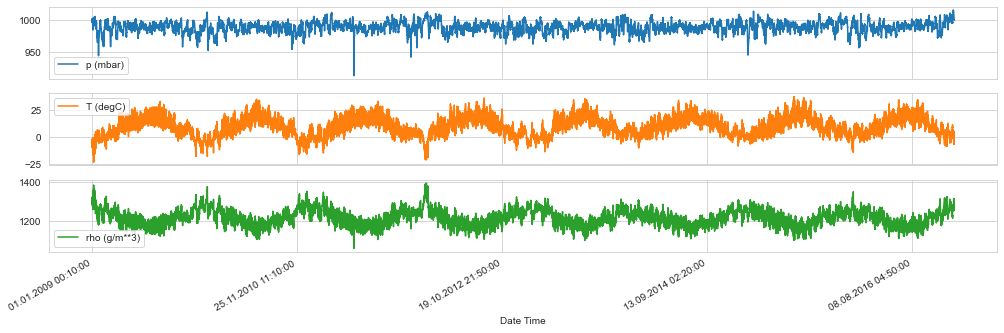

In [8]:
features.plot(subplots=True)

In [9]:
column_indices = {name: i for i, name in enumerate(features.columns)}

n = len(features)
train_df = features[0:int(n*0.7)]
val_df = features[int(n*0.7):int(n*0.9)]
test_df = features[int(n*0.9):]

num_features = features.shape[1]

In [10]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [11]:
train_df

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,0.947798,-1.979098,2.215821
01.01.2009 00:20:00,0.953824,-2.024163,2.265873
01.01.2009 00:30:00,0.949003,-2.035718,2.276616
01.01.2009 00:40:00,0.946592,-2.012608,2.250980
01.01.2009 00:50:00,0.946592,-2.007986,2.246341
...,...,...,...
05.08.2014 01:40:00,0.183649,0.631182,-0.619604
05.08.2014 01:50:00,0.211370,0.626560,-0.609838
05.08.2014 02:00:00,0.224628,0.609228,-0.590061


In [12]:
df_std = (features - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
df_std

,Column,Normalized
0,p (mbar),0.947798
1,p (mbar),0.953824
2,p (mbar),0.949003
3,p (mbar),0.946592
4,p (mbar),0.946592
...,...,...
1261648,rho (g/m**3),1.855197
1261649,rho (g/m**3),1.768764
1261650,rho (g/m**3),1.743128
1261651,rho (g/m**3),1.869358


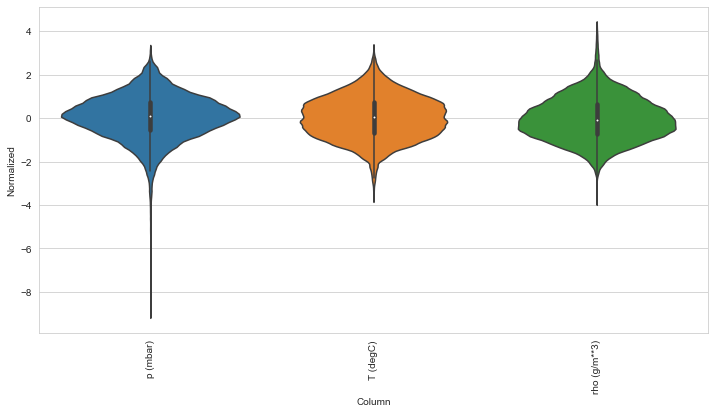

In [13]:

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(features.keys(), rotation=90)

### Modelos de salida única

Todos estos modelos se pueden convertir para predecir múltiples funciones simplemente cambiando la cantidad de unidades en la capa de salida y ajustando las ventanas de entrenamiento para incluir todas las funciones en las labels ( example_labels ):

La función windowGenerator, permite implementar la ventana de datos que pueda utilizarse para hacer la predicción según se requiera. Según la tarea y el tipo de modelo, es posible generar una variedad de ventana de datos. Aquí presentamos unos ejemplos:

Por ejemplo, para hacer una sola predicción 4 horas en el futuro(es decir, 24 periodos ya que cada periodo es de 10 minutos), con 4 horas(24 periodos de historial), se puede definir la siguiente ventana:


<img src="24241.png">

Para hacer una sola predicción 10 minutos en el futuro(es decir, 1 periodos ya que cada periodo es de 10 minutos), con 1 hora(6 periodos de historial), se puede definir la siguiente ventana:

<img src="611.png">

In [14]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [15]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [16]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=64,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [17]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [18]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [19]:
MAX_EPOCHS = 5

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# Configuración basados en las últimas 4 horas(24 periodos) y predicción 24 pasos adelante(4 horas) sin predecir las anteriores para la variable temperatura.

Note que la función WindowGenerator tiene de entrada por defecto a :

self.train_df = train_df

self.val_df = val_df

self.test_df = test_df



In [20]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

# Configuración basados en la última hora y predicción un paso adelante para la temperatura.

In [21]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

Ahora, la función split_window permite convertir la lista de entradas consecutivas en una ventana de entradas y una ventana de etiquetas:

<img src="EjemploDividir.png">

## Ejemplo de tres porciones o slice al incio, en el tiempo 100 y en el timpo 200

In [22]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 3)
Inputs shape: (3, 6, 3)
Labels shape: (3, 1, 1)


In [23]:
example_window

<tf.Tensor: shape=(3, 7, 3), dtype=float64, numpy=
array([[[ 0.94779765, -1.97909842,  2.21582063],
        [ 0.95382407, -2.02416303,  2.26587334],
        [ 0.94900294, -2.03571805,  2.27661636],
        [ 0.94659237, -2.012608  ,  2.25097961],
        [ 0.94659237, -2.00798599,  2.24634058],
        [ 0.94538709, -1.98256493,  2.21850639],
        [ 0.94538709, -1.93287831,  2.1652796 ]],

       [[ 1.38290453, -1.66826819,  2.00315765],
        [ 1.38772566, -1.6728902 ,  2.00877332],
        [ 1.38772566, -1.67982322,  2.01683058],
        [ 1.38893094, -1.66249068,  1.99900693],
        [ 1.38893094, -1.65440216,  1.99021719],
        [ 1.38772566, -1.65440216,  1.99046135],
        [ 1.38652038, -1.65786867,  1.99363542]],

       [[ 1.19005938, -1.5030313 ,  1.77682173],
        [ 1.19729107, -1.5030313 ,  1.77901916],
        [ 1.19608579, -1.50534231,  1.78219324],
        [ 1.20452276, -1.50649781,  1.78487899],
        [ 1.22019143, -1.51111982,  1.79342458],
        [ 1.22

In [24]:
example_labels

<tf.Tensor: shape=(3, 1, 1), dtype=float64, numpy=
array([[[-1.93287831]],

       [[-1.65786867]],

       [[-1.5030313 ]]])>

In [25]:
example_inputs 

<tf.Tensor: shape=(3, 6, 3), dtype=float64, numpy=
array([[[ 0.94779765, -1.97909842,  2.21582063],
        [ 0.95382407, -2.02416303,  2.26587334],
        [ 0.94900294, -2.03571805,  2.27661636],
        [ 0.94659237, -2.012608  ,  2.25097961],
        [ 0.94659237, -2.00798599,  2.24634058],
        [ 0.94538709, -1.98256493,  2.21850639]],

       [[ 1.38290453, -1.66826819,  2.00315765],
        [ 1.38772566, -1.6728902 ,  2.00877332],
        [ 1.38772566, -1.67982322,  2.01683058],
        [ 1.38893094, -1.66249068,  1.99900693],
        [ 1.38893094, -1.65440216,  1.99021719],
        [ 1.38772566, -1.65440216,  1.99046135]],

       [[ 1.19005938, -1.5030313 ,  1.77682173],
        [ 1.19729107, -1.5030313 ,  1.77901916],
        [ 1.19608579, -1.50534231,  1.78219324],
        [ 1.20452276, -1.50649781,  1.78487899],
        [ 1.22019143, -1.51111982,  1.79342458],
        [ 1.22621784, -1.50649781,  1.79098298]]])>

In [26]:
train_df[:w2.total_window_size]

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,0.947798,-1.979098,2.215821
01.01.2009 00:20:00,0.953824,-2.024163,2.265873
01.01.2009 00:30:00,0.949003,-2.035718,2.276616
01.01.2009 00:40:00,0.946592,-2.012608,2.250980
01.01.2009 00:50:00,0.946592,-2.007986,2.246341
01.01.2009 01:00:00,0.945387,-1.982565,2.218506
01.01.2009 01:10:00,0.945387,-1.932878,2.165280


In [27]:
train_df[200:200+w2.total_window_size]

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
02.01.2009 09:30:00,1.190059,-1.503031,1.776822
02.01.2009 09:40:00,1.197291,-1.503031,1.779019
02.01.2009 09:50:00,1.196086,-1.505342,1.782193
02.01.2009 10:00:00,1.204523,-1.506498,1.784879
02.01.2009 10:10:00,1.220191,-1.511120,1.793425
02.01.2009 10:20:00,1.226218,-1.506498,1.790983
02.01.2009 10:30:00,1.227423,-1.503031,1.787321


In [28]:
test_df.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
11.03.2016 20:40:00,1.640835,-0.728844,1.102697
11.03.2016 20:50:00,1.649272,-0.728844,1.104895
11.03.2016 21:00:00,1.654093,-0.734622,1.111975
11.03.2016 21:10:00,1.666146,-0.736933,1.117347
11.03.2016 21:20:00,1.669762,-0.743866,1.125404


In [29]:
test_df.tail(10)

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
31.12.2016 22:30:00,1.420268,-1.523830,1.869114
31.12.2016 22:40:00,1.421474,-1.566584,1.910377
31.12.2016 22:50:00,1.405805,-1.524986,1.864719
31.12.2016 23:00:00,1.392547,-1.486854,1.824189
31.12.2016 23:10:00,1.380494,-1.506498,1.841280
31.12.2016 23:20:00,1.375673,-1.520364,1.855197
31.12.2016 23:30:00,1.358799,-1.439479,1.768764
31.12.2016 23:40:00,1.345541,-1.417524,1.743128
31.12.2016 23:50:00,1.344335,-1.541163,1.869358


In [30]:
print(w2.total_window_size)
print(test_df.shape)
42056-7

7
(42056, 3)


42049

In [31]:
np.array(test_df[42050:42050+w2.total_window_size-1])
###Este se puede usar para hacer una predición final

array([[ 1.38049397, -1.50649781,  1.84127985],
       [ 1.37567284, -1.52036384,  1.85519695],
       [ 1.35879889, -1.43947865,  1.76876446],
       [ 1.34554078, -1.4175241 ,  1.74312771],
       [ 1.3443355 , -1.54116289,  1.8693582 ],
       [ 1.34554078, -1.60933755,  1.9382112 ]])

## Visualización

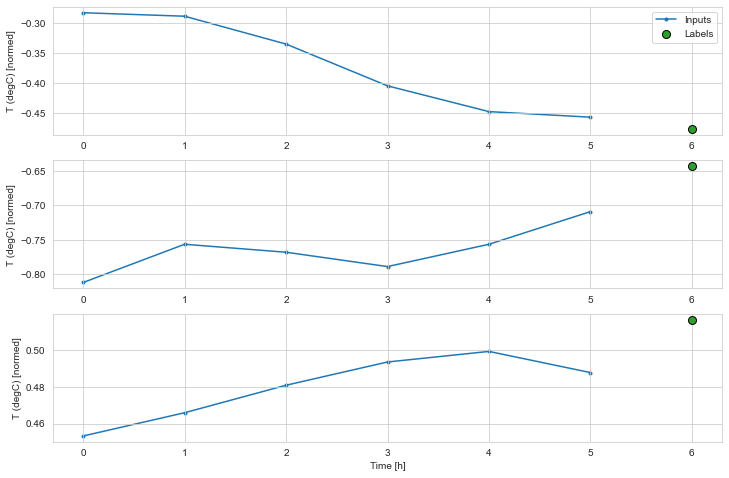

In [32]:
w2.plot()

## Las otras columnas

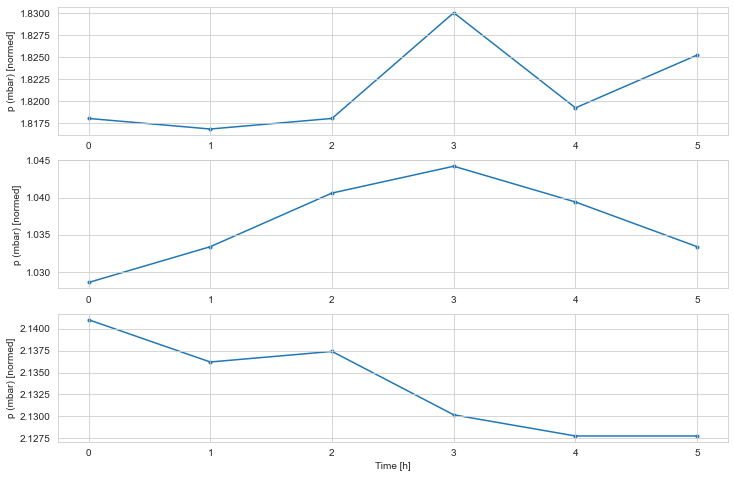

In [33]:
w2.plot(plot_col='p (mbar)')

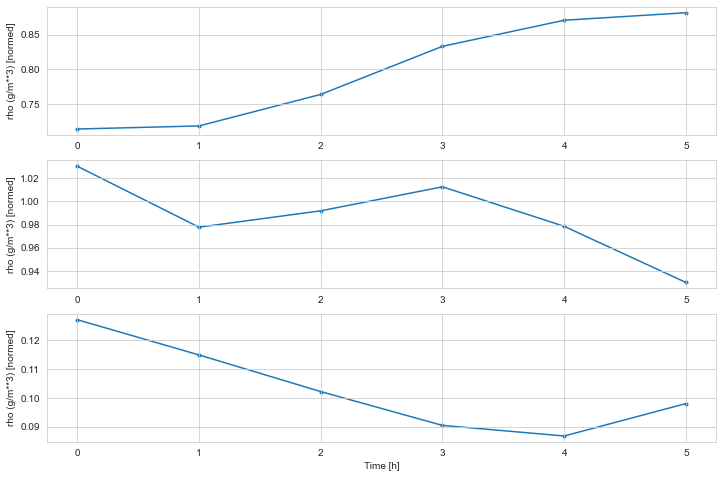

In [34]:
w2.plot(plot_col='rho (g/m**3)')

## Crear objeto tensorflow

El método make_dataset tomará un data frame de serie temporal y lo convertirá en un tf.data.Dataset de (input_window, label_window) usando la función tf.keras.utils.timeseries_dataset_from_array. el objeto WindowGenerator contiene datos de entrenamiento, validación y prueba.

In [35]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [36]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (64, 6, 3)
Labels shape (batch, time, features): (64, 1, 1)


Se itera sobre el conjunto Dataset para producir lotes concretos

## Modelos de un solo paso

El modelo mas simple se puede crear a partir de este tipo de datos, y es que le predice el valor de una sola característica: 1 paso de tiempo(10 minutos) hacia el futuro basandose únicamente en las condiciones actuales, es decir, basados en la información inmediantamente anterior:

In [37]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [38]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (64, 1, 3)
Labels shape (batch, time, features): (64, 1, 1)


In [39]:
example_inputs

<tf.Tensor: shape=(64, 1, 3), dtype=float32, numpy=
array([[[-0.95534295, -0.11989456, -0.1662001 ]],

       [[ 0.73687327, -0.75195456,  0.88539517]],

       [[ 1.308177  , -0.11527254,  0.39878514]],

       [[ 0.7670053 ,  1.3429719 , -1.02906   ]],

       [[ 0.40542066,  0.5814956 , -0.4513785 ]],

       [[ 1.0044459 ,  0.2856869 , -0.05681662]],

       [[ 1.6516825 , -1.828883  ,  2.2570837 ]],

       [[-1.1072085 , -0.4884999 ,  0.16146204]],

       [[ 1.4371423 , -0.57862914,  0.8954057 ]],

       [[-0.03571263,  0.3723496 , -0.410848  ]],

       [[-0.22494192,  0.34692854, -0.41914943]],

       [[ 0.0510677 ,  0.99978757, -1.0090389 ]],

       [[-2.4607403 , -1.1702465 ,  0.48131105]],

       [[-0.10923484,  0.39199314, -0.41304544]],

       [[ 0.9731086 ,  0.10889498,  0.11409508]],

       [[ 0.21137023,  0.01529926,  0.02912755]],

       [[ 0.32225618,  0.2417778 , -0.15765452]],

       [[ 0.5151013 , -0.07367445,  0.17171673]],

       [[ 0.04745185, -0.59596


El modelo base, es un modelo simple, es decir, la predicción un paso adelante de la temperatura actual es la actual temperatura, ya que la temperatura no cambia drámaticamente en un periodod e 10 minutos.

### Modelo Base

In [40]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [41]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

1315/1315 [==============================] - 2s 1ms/step - loss: 7.7077e-04 - mean_absolute_error: 0.0180


## Modelo de mas grande ventana

Esto permite evaluar mas detalladamente la evolución del comportamineto del modelo.

In [42]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,label_columns=['T (degC)'])


wide_window



Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [43]:
for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (64, 24, 3)
Labels shape (batch, time, features): (64, 24, 1)


In [44]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (64, 24, 3)
Output shape: (64, 24, 1)


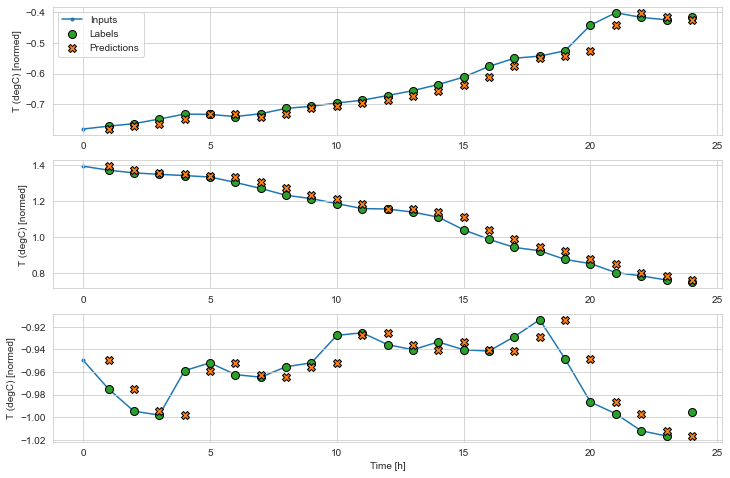

In [45]:
wide_window.plot(baseline)

In [46]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

1314/1314 [==============================] - 2s 1ms/step - loss: 7.7096e-04 - mean_absolute_error: 0.0180


## Denso(MLP)

In [47]:
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [48]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/5
4600/4600 [==============================] - 9s 2ms/step - loss: 0.0029 - mean_absolute_error: 0.0244 - val_loss: 8.8298e-04 - val_mean_absolute_error: 0.0207
Epoch 2/5
4600/4600 [==============================] - 8s 2ms/step - loss: 9.4750e-04 - mean_absolute_error: 0.0213 - val_loss: 9.2211e-04 - val_mean_absolute_error: 0.0212
Epoch 3/5
1315/1315 [==============================] - 1s 1ms/step - loss: 0.0011 - mean_absolute_error: 0.0223


<AxesSubplot:>

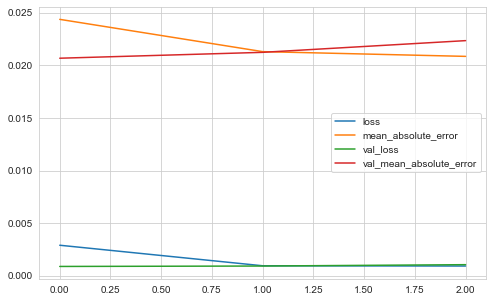

In [49]:
pd.DataFrame(history.history).plot(figsize=(8,5))

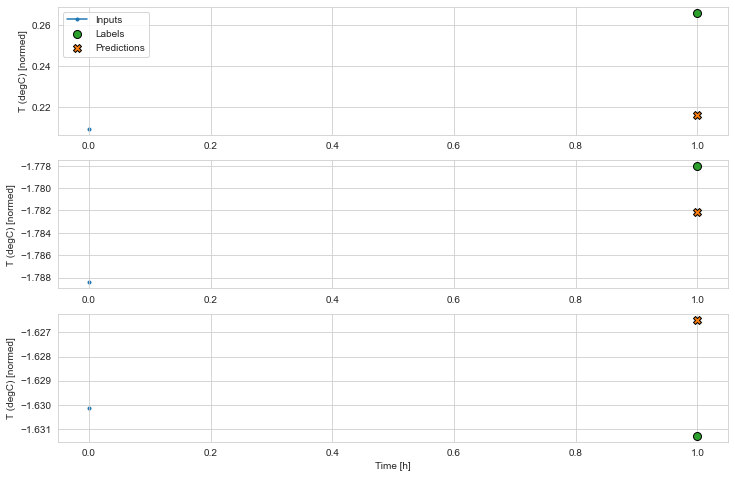

In [50]:
single_step_window.plot(dense)

## Predicción

In [51]:
print(test_df.shape)
print(test_df.tail(10))

input_predict=tf.constant(np.array(test_df.iloc[42055]),dtype=tf.float32, shape=(1,1,3))
print(input_predict)


(42056, 3)
                     p (mbar)  T (degC)  rho (g/m**3)
Date Time                                            
31.12.2016 22:30:00  1.420268 -1.523830      1.869114
31.12.2016 22:40:00  1.421474 -1.566584      1.910377
31.12.2016 22:50:00  1.405805 -1.524986      1.864719
31.12.2016 23:00:00  1.392547 -1.486854      1.824189
31.12.2016 23:10:00  1.380494 -1.506498      1.841280
31.12.2016 23:20:00  1.375673 -1.520364      1.855197
31.12.2016 23:30:00  1.358799 -1.439479      1.768764
31.12.2016 23:40:00  1.345541 -1.417524      1.743128
31.12.2016 23:50:00  1.344335 -1.541163      1.869358
01.01.2017 00:00:00  1.345541 -1.609338      1.938211
tf.Tensor([[[ 1.3455408 -1.6093376  1.9382112]]], shape=(1, 1, 3), dtype=float32)


In [52]:
dense.predict(input_predict)

array([[[-1.605124]]], dtype=float32)

# Denso(mlp) de varios pasos

 <img src="DensoUnpasoadel1carac.png">

Aquí el modelo tomará múltiples pasos de tiempo como entrada para producir una única salida.

Cree un WindowGenerator que produzca lotes de entradas de tres periodos(30 minutos) y etiquetas de un minuto:

Tenga en cuenta que el parámetro de shift de la Window es relativo al final de las dos ventanas.

In [53]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3 periods of inputs, predict 1 period into the future.')

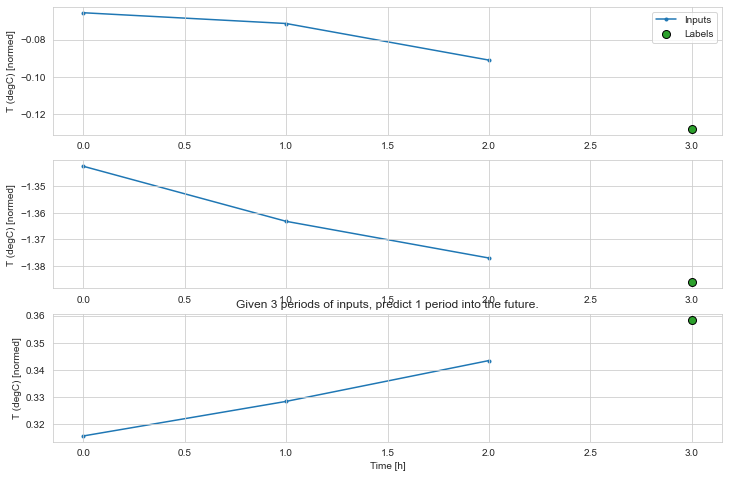

In [54]:
conv_window.plot()
plt.title("Given 3 periods of inputs, predict 1 period into the future.")

In [55]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [56]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (64, 3, 3)
Output shape: (64, 1, 1)


In [57]:
conv_window.example[0]

<tf.Tensor: shape=(64, 3, 3), dtype=float32, numpy=
array([[[ 4.0421537e-01, -6.5585926e-02,  1.3533697e-01],
        [ 3.8734144e-01, -7.1363442e-02,  1.3655776e-01],
        [ 3.9336783e-01, -9.1006987e-02,  1.5633468e-01]],

       [[ 2.1494641e+00, -1.3424164e+00,  1.8615451e+00],
        [ 2.1530797e+00, -1.3632154e+00,  1.8842520e+00],
        [ 2.1542852e+00, -1.3770815e+00,  1.8984132e+00]],

       [[-3.8123187e-02,  3.1572998e-01, -3.4492490e-01],
        [-3.8123187e-02,  3.2844049e-01, -3.5688874e-01],
        [-2.4865083e-02,  3.4346202e-01, -3.6714342e-01]],

       [[ 4.9702212e-01,  1.7531754e+00, -1.4822202e+00],
        [ 5.0304854e-01,  1.7381538e+00, -1.4678148e+00],
        [ 5.0425380e-01,  1.7127328e+00, -1.4482820e+00]],

       [[ 2.2583361e-01,  4.4186831e-02, -2.7029153e-02],
        [ 2.1860193e-01,  1.9921273e-02, -6.0314308e-03],
        [ 2.1619135e-01,  2.7772729e-04,  1.1792217e-02]],

       [[ 6.4888769e-01, -5.8671767e-01,  7.0056635e-01],
        [ 

In [58]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

1315/1315 [==============================] - 1s 1ms/step - loss: 5.7638e-04 - mean_absolute_error: 0.0158


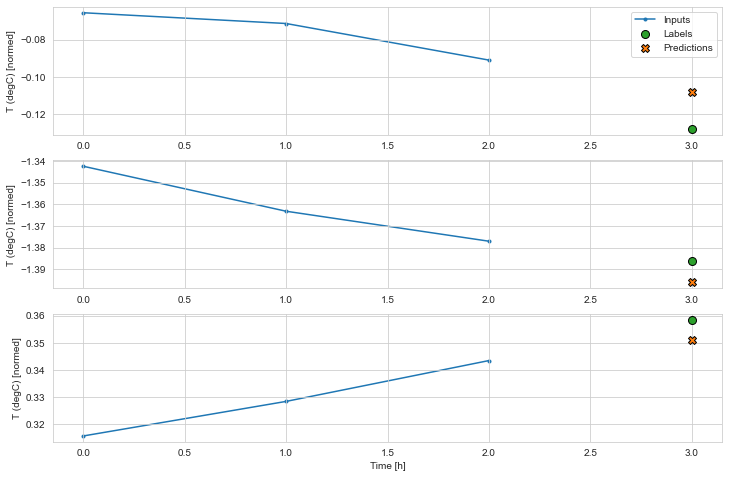

In [59]:
conv_window.plot(multi_step_dense)

## Predicción

In [60]:
np.array(test_df.iloc[42052:42055])

array([[ 1.35879889, -1.43947865,  1.76876446],
       [ 1.34554078, -1.4175241 ,  1.74312771],
       [ 1.3443355 , -1.54116289,  1.8693582 ]])

In [61]:
print(test_df.shape)
print(test_df.tail(10))

input_predict=tf.constant(np.array(test_df.iloc[42053:42056]),dtype=tf.float32, shape=(1,3,3))
print(input_predict)


(42056, 3)
                     p (mbar)  T (degC)  rho (g/m**3)
Date Time                                            
31.12.2016 22:30:00  1.420268 -1.523830      1.869114
31.12.2016 22:40:00  1.421474 -1.566584      1.910377
31.12.2016 22:50:00  1.405805 -1.524986      1.864719
31.12.2016 23:00:00  1.392547 -1.486854      1.824189
31.12.2016 23:10:00  1.380494 -1.506498      1.841280
31.12.2016 23:20:00  1.375673 -1.520364      1.855197
31.12.2016 23:30:00  1.358799 -1.439479      1.768764
31.12.2016 23:40:00  1.345541 -1.417524      1.743128
31.12.2016 23:50:00  1.344335 -1.541163      1.869358
01.01.2017 00:00:00  1.345541 -1.609338      1.938211
tf.Tensor(
[[[ 1.3455408 -1.4175241  1.7431277]
  [ 1.3443356 -1.5411628  1.8693582]
  [ 1.3455408 -1.6093376  1.9382112]]], shape=(1, 3, 3), dtype=float32)


In [62]:
multi_step_dense(input_predict)

<tf.Tensor: shape=(1, 1, 1), dtype=float32, numpy=array([[[-1.6300944]]], dtype=float32)>

# Red(convolucional)

Una capa de convolución ( tf.keras.layers.Conv1D ) también toma varios pasos de tiempo como entrada para cada predicción.

A continuación se muestra el mismo modelo que multi_step_dense , reescrito con una convolución.

Tenga en cuenta los cambios:

El tf.keras.layers.Flatten y el primer tf.keras.layers.Dense se reemplazan por un tf.keras.layers.Conv1D .
El tf.keras.layers.Reshape ya no es necesario ya que la convolución mantiene el eje del tiempo en su salida.

In [63]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Ejecútelo en un lote de ejemplo para verificar que el modelo produce resultados con la forma esperada:

In [64]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (64, 3, 3)
Output shape: (64, 1, 1)


In [65]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

1315/1315 [==============================] - 2s 1ms/step - loss: 5.7717e-04 - mean_absolute_error: 0.0159


La diferencia entre este conv_model y el modelo multi_step_dense es que el modelo conv_model se puede ejecutar en entradas de cualquier longitud. La capa convolucional se aplica a una ventana deslizante de entradas:
    
 <img src="Convo1carac.png">

In [66]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (64, 24, 3)
Labels shape: (64, 24, 1)
Output shape: (64, 22, 1)


Tenga en cuenta que la salida es más corta que la entrada. Para que el entrenamiento o el trazado funcionen, necesita que las etiquetas y la predicción tengan la misma longitud. Por lo tanto, construya un WindowGenerator para producir ventanas anchas con algunos pasos de tiempo de entrada adicionales para que la etiqueta y la longitud de la predicción coincidan:

In [67]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [68]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (64, 26, 3)
Labels shape: (64, 24, 1)
Output shape: (64, 24, 1)


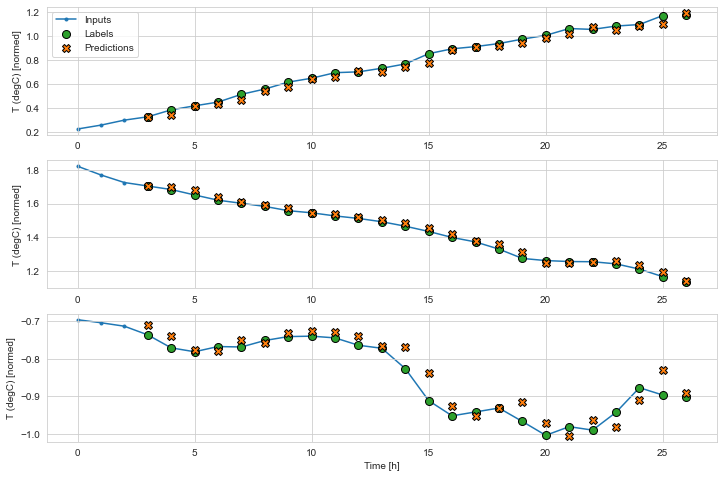

In [69]:
wide_conv_window.plot(conv_model)

## Predicción

In [70]:
np.array(test_df.iloc[(42056-24):42056]).shape

(24, 3)

In [71]:
print(test_df.shape)
print(test_df.tail(10))

input_predict_conv=tf.constant(np.array(test_df.iloc[(42056-24):42056]),dtype=tf.float32, shape=(1,24,3))
print(input_predict_conv)

(42056, 3)
                     p (mbar)  T (degC)  rho (g/m**3)
Date Time                                            
31.12.2016 22:30:00  1.420268 -1.523830      1.869114
31.12.2016 22:40:00  1.421474 -1.566584      1.910377
31.12.2016 22:50:00  1.405805 -1.524986      1.864719
31.12.2016 23:00:00  1.392547 -1.486854      1.824189
31.12.2016 23:10:00  1.380494 -1.506498      1.841280
31.12.2016 23:20:00  1.375673 -1.520364      1.855197
31.12.2016 23:30:00  1.358799 -1.439479      1.768764
31.12.2016 23:40:00  1.345541 -1.417524      1.743128
31.12.2016 23:50:00  1.344335 -1.541163      1.869358
01.01.2017 00:00:00  1.345541 -1.609338      1.938211
tf.Tensor(
[[[ 1.5359753 -1.2141557  1.5839356]
  [ 1.538386  -1.3008183  1.6725656]
  [ 1.5420017 -1.4209906  1.794157 ]
  [ 1.5347701 -1.4337012  1.8046559]
  [ 1.5275384 -1.4521892  1.8227237]
  [ 1.5227172 -1.4094356  1.7770659]
  [ 1.5106645 -1.3701485  1.7340938]
  [ 1.4937905 -1.3539715  1.7140727]
  [ 1.4925852 -1.3424164  1.701864

In [72]:
conv_model.predict(input_predict_conv)

array([[[-1.4209603],
        [-1.4205841],
        [-1.4434181],
        [-1.3758243],
        [-1.3312417],
        [-1.3274292],
        [-1.3228152],
        [-1.322904 ],
        [-1.3226461],
        [-1.3419473],
        [-1.3839531],
        [-1.421639 ],
        [-1.5299895],
        [-1.5596151],
        [-1.4926677],
        [-1.4500526],
        [-1.495762 ],
        [-1.5105146],
        [-1.3864908],
        [-1.3848268],
        [-1.5565377],
        [-1.6005627]]], dtype=float32)

## RNN(LSTM)

In [73]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [74]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (64, 24, 3)
Output shape: (64, 24, 1)


In [75]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

1314/1314 [==============================] - 5s 4ms/step - loss: 5.3137e-04 - mean_absolute_error: 0.0146


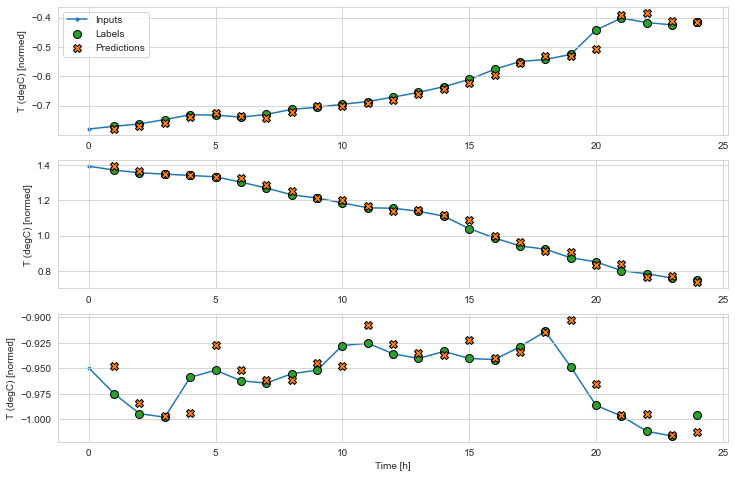

In [76]:
wide_window.plot(lstm_model)

# Predicción

In [77]:
lstm_model(input_predict_conv)

<tf.Tensor: shape=(1, 24, 1), dtype=float32, numpy=
array([[[-1.2221076],
        [-1.3376164],
        [-1.4787121],
        [-1.4358974],
        [-1.4867344],
        [-1.399156 ],
        [-1.3734205],
        [-1.3581486],
        [-1.3447676],
        [-1.3421707],
        [-1.3397487],
        [-1.359539 ],
        [-1.4028184],
        [-1.4418625],
        [-1.5716841],
        [-1.5833925],
        [-1.5183911],
        [-1.4903181],
        [-1.529948 ],
        [-1.5332675],
        [-1.4092894],
        [-1.4253815],
        [-1.6008918],
        [-1.6279615]]], dtype=float32)>

## Rendimiento

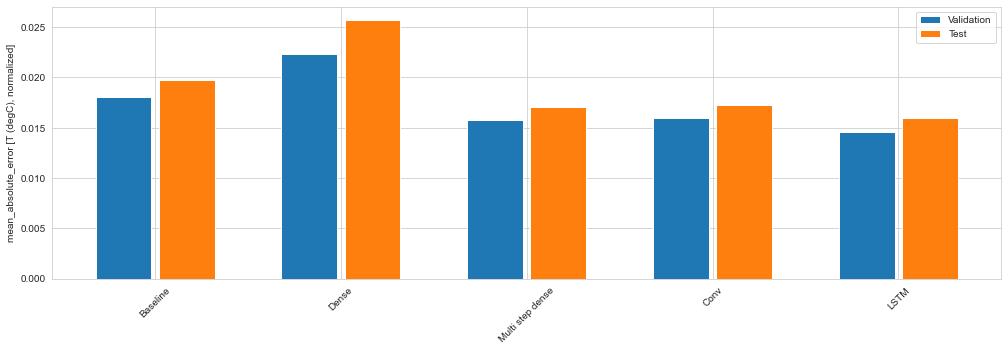

In [78]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


# Predicción Multivariada( Mútiples Salidas)

Los modelos anteriores se pueden usar para predecir mas de una sola salida, en vez de predecir únicamente la temperatura(T (degC)),  procederemos a predecir 'p (mbar)', 'T (degC)', 'rho (g/m**3)' al mismo tiempo, la presión del aire, temperatura y la densidad del aire. Se debe cambiar las unidades de la capa de salida y ajustando la ventana de entrenamineto para incluir las funciones en las labels. Note que ahora la salida es 3. En este caso es como si se deseara predecir la observación siguiente con base en la última información disponible o con base en los últimos 24 periodos.

In [79]:
# Esta configuración consiste en que solo la última información 
#es usada para predecir el siguiente paso adelante. Note que batch es 64. En este caso 
##como no se especifica  Ninguna variable, entonces se toman todas como respuesta

single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)


# Esta configuración consiste en que los últimos 24 periodos de información 
#es usada para predecir el siguiente paso adelante. Note que batch es 32.
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (64, 24, 3)
Labels shape (batch, time, features): (64, 24, 3)


In [80]:
single_step_window.example[0] 

<tf.Tensor: shape=(64, 1, 3), dtype=float32, numpy=
array([[[ 0.6874567 ,  0.01067725,  0.11800163]],

       [[ 0.39336783,  0.6254047 , -0.5187665 ]],

       [[ 0.6054975 ,  0.3711941 , -0.25165597]],

       [[ 0.1860593 ,  1.0448521 , -0.9958543 ]],

       [[-0.43948215, -1.545785  ,  1.3971536 ]],

       [[-0.71067065,  1.1338259 , -1.2473387 ]],

       [[ 1.19247   , -2.393924  ,  2.733439  ]],

       [[-0.7938351 ,  0.6046057 , -0.7775757 ]],

       [[ 0.26319736, -2.23562   ,  2.3093338 ]],

       [[ 0.9779297 ,  0.21751224,  0.00519991]],

       [[-0.00678585,  0.48558888, -0.4157312 ]],

       [[-1.5712421 , -0.307086  , -0.12469298]],

       [[-0.6516118 , -0.60173917,  0.3785199 ]],

       [[ 0.59465   ,  0.6924239 , -0.49923375]],

       [[-1.1771148 , -0.8212847 ,  0.48204353]],

       [[-0.7215182 , -2.2321534 ,  2.0410023 ]],

       [[ 1.3925468 ,  0.91081387, -0.4772594 ]],

       [[ 0.87186486,  0.66122526, -0.45015767]],

       [[ 1.244297  , -1.52383

In [81]:
wide_window.example[0]

<tf.Tensor: shape=(64, 24, 3), dtype=float32, numpy=
array([[[ 0.0980737 ,  0.03725382, -0.02043685],
        [ 0.07878918,  0.03956482, -0.02751747],
        [ 0.08240503,  0.03956482, -0.02654083],
        ...,
        [ 0.3355143 ,  0.01529926,  0.05281103],
        [ 0.342746  ,  0.02223228,  0.04817199],
        [ 0.36323577,  0.0303208 ,  0.0457304 ]],

       [[-0.1321352 , -0.3983707 ,  0.311376  ],
        [-0.13695633, -0.3879712 ,  0.29965636],
        [-0.13695633, -0.3995262 ,  0.3108877 ],
        ...,
        [-0.16588311, -0.36486113,  0.2691364 ],
        [-0.16949895, -0.33135155,  0.23568654],
        [-0.16708839, -0.318641  ,  0.22372273]],

       [[ 0.8983811 ,  0.10311747,  0.13313952],
        [ 0.8971758 ,  0.0742299 ,  0.1592646 ],
        [ 0.8983811 ,  0.0314763 ,  0.19784181],
        ...,
        [ 0.99480367, -0.41223675,  0.6361082 ],
        [ 0.9887772 , -0.4434353 ,  0.6624775 ],
        [ 0.98154557, -0.4757894 ,  0.69006747]],

       ...,

       

## Modelo Base

Usaremos el modelo base anterior.

In [82]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [83]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

1314/1314 [==============================] - 2s 1ms/step - loss: 5.3296e-04 - mean_absolute_error: 0.0147


## Modelo Denso(MLP)

In [84]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [85]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

1315/1315 [==============================] - 2s 1ms/step - loss: 6.5921e-04 - mean_absolute_error: 0.0178


In [86]:
single_step_window.example[0]

<tf.Tensor: shape=(64, 1, 3), dtype=float32, numpy=
array([[[ 0.6874567 ,  0.01067725,  0.11800163]],

       [[ 0.39336783,  0.6254047 , -0.5187665 ]],

       [[ 0.6054975 ,  0.3711941 , -0.25165597]],

       [[ 0.1860593 ,  1.0448521 , -0.9958543 ]],

       [[-0.43948215, -1.545785  ,  1.3971536 ]],

       [[-0.71067065,  1.1338259 , -1.2473387 ]],

       [[ 1.19247   , -2.393924  ,  2.733439  ]],

       [[-0.7938351 ,  0.6046057 , -0.7775757 ]],

       [[ 0.26319736, -2.23562   ,  2.3093338 ]],

       [[ 0.9779297 ,  0.21751224,  0.00519991]],

       [[-0.00678585,  0.48558888, -0.4157312 ]],

       [[-1.5712421 , -0.307086  , -0.12469298]],

       [[-0.6516118 , -0.60173917,  0.3785199 ]],

       [[ 0.59465   ,  0.6924239 , -0.49923375]],

       [[-1.1771148 , -0.8212847 ,  0.48204353]],

       [[-0.7215182 , -2.2321534 ,  2.0410023 ]],

       [[ 1.3925468 ,  0.91081387, -0.4772594 ]],

       [[ 0.87186486,  0.66122526, -0.45015767]],

       [[ 1.244297  , -1.52383

# Predicción

In [87]:
print(np.array(test_df.iloc[(42055):42056]).shape)

print(test_df.shape)
print(test_df.tail(10))



print(np.array(test_df.iloc[(42055):42056]))

(1, 3)
(42056, 3)
                     p (mbar)  T (degC)  rho (g/m**3)
Date Time                                            
31.12.2016 22:30:00  1.420268 -1.523830      1.869114
31.12.2016 22:40:00  1.421474 -1.566584      1.910377
31.12.2016 22:50:00  1.405805 -1.524986      1.864719
31.12.2016 23:00:00  1.392547 -1.486854      1.824189
31.12.2016 23:10:00  1.380494 -1.506498      1.841280
31.12.2016 23:20:00  1.375673 -1.520364      1.855197
31.12.2016 23:30:00  1.358799 -1.439479      1.768764
31.12.2016 23:40:00  1.345541 -1.417524      1.743128
31.12.2016 23:50:00  1.344335 -1.541163      1.869358
01.01.2017 00:00:00  1.345541 -1.609338      1.938211
[[ 1.34554078 -1.60933755  1.9382112 ]]


In [88]:
input_predict_denso=tf.constant(np.array(test_df.iloc[(42055):42056]),dtype=tf.float32, shape=(1,1,3))
print(input_predict_denso)

tf.Tensor([[[ 1.3455408 -1.6093376  1.9382112]]], shape=(1, 1, 3), dtype=float32)


In [89]:
dense.predict(input_predict_denso)

array([[[ 1.3647126, -1.5955553,  1.9216708]]], dtype=float32)

## Red Neuronal Recurrente(LSTM)

In [90]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

1314/1314 [==============================] - 3s 2ms/step - loss: 3.6941e-04 - mean_absolute_error: 0.0118

CPU times: user 6min 15s, sys: 1min 4s, total: 7min 20s
Wall time: 2min 31s


## PRedicción

In [91]:
wide_window.example[0]

<tf.Tensor: shape=(64, 24, 3), dtype=float32, numpy=
array([[[ 1.4733007 , -0.37063864,  0.7098444 ],
        [ 1.4588373 , -0.3983707 ,  0.73133045],
        [ 1.4467845 , -0.3983707 ,  0.7281564 ],
        ...,
        [ 1.3154087 , -0.3521506 ,  0.6473396 ],
        [ 1.325051  , -0.3509951 ,  0.64856035],
        [ 1.3274616 , -0.3567726 ,  0.65393186]],

       [[ 0.3077928 , -0.23660032,  0.29062244],
        [ 0.33189845, -0.25046635,  0.3101552 ],
        [ 0.35841465, -0.2735764 ,  0.33847773],
        ...,
        [ 0.6838409 , -0.28975347,  0.44566378],
        [ 0.68504614, -0.29206446,  0.44859368],
        [ 0.69227785, -0.25971037,  0.42002702]],

       [[ 0.4174735 ,  2.009697  , -1.7263798 ],
        [ 0.41867876,  1.9415222 , -1.6707114 ],
        [ 0.42108932,  1.9172567 , -1.6511786 ],
        ...,
        [ 0.6175503 ,  1.2932853 , -1.0754503 ],
        [ 0.6259873 ,  1.2655532 , -1.0500578 ],
        [ 0.63442427,  1.2355101 , -1.0217352 ]],

       ...,

       

In [92]:
print(np.array(test_df.iloc[(42056-24):42056]).shape)

print(test_df.shape)
print(test_df.tail(24))



print(np.array(test_df.iloc[(42056-24):42056]))

(24, 3)
(42056, 3)
                     p (mbar)  T (degC)  rho (g/m**3)
Date Time                                            
31.12.2016 20:10:00  1.535975 -1.214156      1.583936
31.12.2016 20:20:00  1.538386 -1.300818      1.672566
31.12.2016 20:30:00  1.542002 -1.420991      1.794157
31.12.2016 20:40:00  1.534770 -1.433701      1.804656
31.12.2016 20:50:00  1.527538 -1.452189      1.822724
31.12.2016 21:00:00  1.522717 -1.409436      1.777066
31.12.2016 21:10:00  1.510664 -1.370148      1.734094
31.12.2016 21:20:00  1.493790 -1.353971      1.714073
31.12.2016 21:30:00  1.492585 -1.342416      1.701865
31.12.2016 21:40:00  1.487764 -1.338950      1.696982
31.12.2016 21:50:00  1.464864 -1.338950      1.690633
31.12.2016 22:00:00  1.451606 -1.351660      1.701132
31.12.2016 22:10:00  1.445579 -1.386326      1.734338
31.12.2016 22:20:00  1.428705 -1.424457      1.770229
31.12.2016 22:30:00  1.420268 -1.523830      1.869114
31.12.2016 22:40:00  1.421474 -1.566584      1.910377
31.12.201

In [93]:
input_predict_lstm=tf.constant(np.array(test_df.iloc[(42056-24):42056]),dtype=tf.float32, shape=(1,24,3))
print(input_predict_lstm)

tf.Tensor(
[[[ 1.5359753 -1.2141557  1.5839356]
  [ 1.538386  -1.3008183  1.6725656]
  [ 1.5420017 -1.4209906  1.794157 ]
  [ 1.5347701 -1.4337012  1.8046559]
  [ 1.5275384 -1.4521892  1.8227237]
  [ 1.5227172 -1.4094356  1.7770659]
  [ 1.5106645 -1.3701485  1.7340938]
  [ 1.4937905 -1.3539715  1.7140727]
  [ 1.4925852 -1.3424164  1.7018647]
  [ 1.4877641 -1.3389499  1.6969815]
  [ 1.4648638 -1.3389499  1.6906334]
  [ 1.4516056 -1.3516605  1.7011323]
  [ 1.4455792 -1.3863255  1.7343379]
  [ 1.4287052 -1.4244571  1.7702295]
  [ 1.4202683 -1.5238303  1.869114 ]
  [ 1.4214735 -1.566584   1.910377 ]
  [ 1.4058049 -1.5249859  1.8647192]
  [ 1.3925468 -1.4868543  1.8241887]
  [ 1.380494  -1.5064979  1.8412799]
  [ 1.3756728 -1.5203638  1.855197 ]
  [ 1.3587989 -1.4394786  1.7687645]
  [ 1.3455408 -1.4175241  1.7431277]
  [ 1.3443356 -1.5411628  1.8693582]
  [ 1.3455408 -1.6093376  1.9382112]]], shape=(1, 24, 3), dtype=float32)


In [94]:
lstm_model.predict(input_predict_lstm)

array([[[ 1.5518019, -1.2248346,  1.5937284],
        [ 1.5487134, -1.3294894,  1.6951667],
        [ 1.5445359, -1.4648842,  1.8358394],
        [ 1.534745 , -1.4321592,  1.8035518],
        [ 1.5286541, -1.4719213,  1.8412775],
        [ 1.5222514, -1.3882638,  1.7559549],
        [ 1.5079601, -1.3607204,  1.7227265],
        [ 1.4872644, -1.346569 ,  1.7029867],
        [ 1.4904528, -1.334021 ,  1.6910386],
        [ 1.4836128, -1.3335485,  1.6880512],
        [ 1.4537888, -1.3325908,  1.6789714],
        [ 1.4434834, -1.3538398,  1.6979805],
        [ 1.4394193, -1.3993706,  1.7429596],
        [ 1.4182851, -1.440086 ,  1.7798204],
        [ 1.4141071, -1.5743269,  1.9157922],
        [ 1.4182656, -1.5822659,  1.9267193],
        [ 1.3976581, -1.513919 ,  1.8512725],
        [ 1.3856215, -1.4836714,  1.8166734],
        [ 1.373281 , -1.5240655,  1.854703 ],
        [ 1.3697968, -1.526939 ,  1.8586646],
        [ 1.3483696, -1.4000204,  1.7251225],
        [ 1.3385777, -1.4172913,  

## Rendimiento

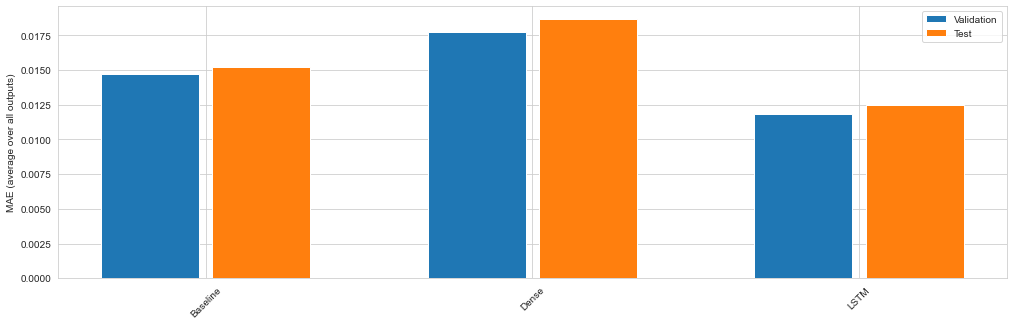

In [95]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

# Varios pasos adelante

Hay dos enfoques aproximados para esto:

1) Predicciones de disparo único donde se predice la serie temporal completa a la vez.

2) Predicciones autorregresivas donde el modelo solo hace predicciones de un solo paso y su salida se retroalimenta como su entrada.

Para el modelo de varios pasos, los datos de entrenamiento nuevamente consisten en muestras por 10 minutos. Sin embargo, aquí, los modelos aprenderán a predecir 24 periodos(4 horas) en el futuro, dadas las 24 periodos del pasado(4 horas).

Aquí hay un objeto de Window que genera estos segmentos a partir del conjunto de datos:

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

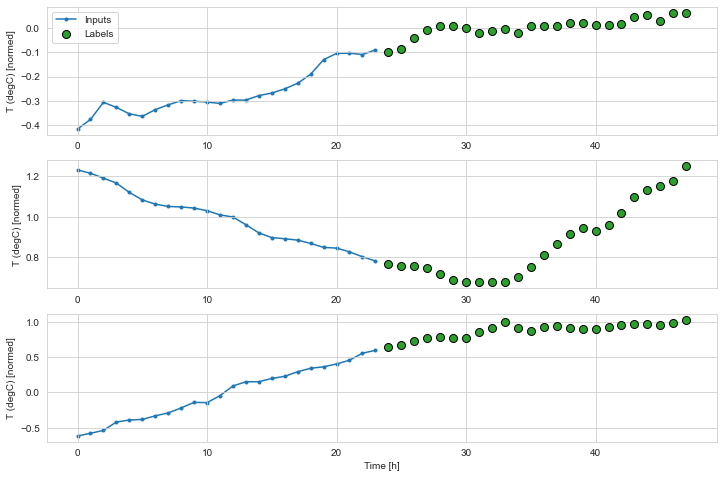

In [96]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window
## Note que el nombre del eje Y está mal.

In [97]:
multi_window.example[0]

<tf.Tensor: shape=(64, 24, 3), dtype=float32, numpy=
array([[[ 0.42832103, -0.41570324,  0.47789285],
        [ 0.436758  , -0.37641615,  0.44029227],
        [ 0.43193686, -0.3059305 ,  0.37095094],
        ...,
        [ 0.27163434, -0.10371751,  0.14266175],
        [ 0.25476038, -0.10949503,  0.14437087],
        [ 0.23909172, -0.08985148,  0.12337314]],

       [[ 0.2885083 ,  1.2320436 , -1.1150042 ],
        [ 0.29212412,  1.2158666 , -1.1027962 ],
        [ 0.29573998,  1.191601  , -1.0805777 ],
        ...,
        [ 0.28127658,  0.82761765, -0.7626819 ],
        [ 0.27645546,  0.8033521 , -0.7426608 ],
        [ 0.26199207,  0.7825531 , -0.72630215]],

       [[ 0.55367035, -0.61676073,  0.7254706 ],
        [ 0.5801866 , -0.57862914,  0.6956832 ],
        [ 0.5934447 , -0.53703105,  0.65832675],
        ...,
        [ 0.63442427,  0.4578568 , -0.2580041 ],
        [ 0.63201374,  0.55723006, -0.3493198 ],
        [ 0.63442427,  0.59767264, -0.3854554 ]],

       ...,

       

# Modelo Línea de base

Una línea de base simple para esta tarea es repetir el último paso de tiempo de entrada para el número requerido de pasos de tiempo de salida:
 <img src="LineadeBase.png">

1314/1314 [==============================] - 2s 1ms/step - loss: 0.0363 - mean_absolute_error: 0.1210


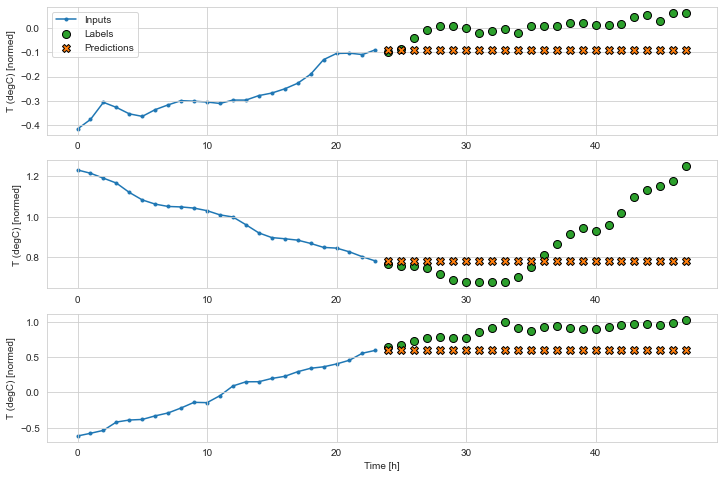

In [98]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Dado que esta tarea es predecir 24 periodos en el futuro, dadas las 24 periodos del pasado, otro enfoque simple es repetir el las 4 horas anteriores, asumiendo que lñas 4 horas siguientes será similar:

1314/1314 [==============================] - 2s 1ms/step - loss: 0.0904 - mean_absolute_error: 0.2165


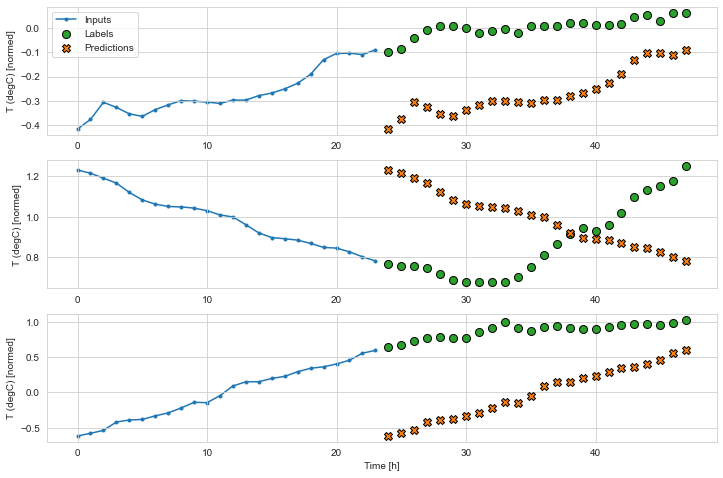

In [99]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

# Modelos de Disparo Único

Un enfoque de alto nivel para este problema es usar un modelo de "disparo único", donde el modelo realiza la predicción de secuencia completa en un solo paso. Esto se puede implementar de manera eficiente como unidades de salida tf.keras.layers.Dense con OUT_STEPS*features . El modelo solo necesita remodelar esa salida según lo requerido (OUTPUT_STEPS, features) .



# Modelo Lineal

 <img src="ModeloLineal.png">

1314/1314 [==============================] - 2s 1ms/step - loss: 0.0351 - mean_absolute_error: 0.1209


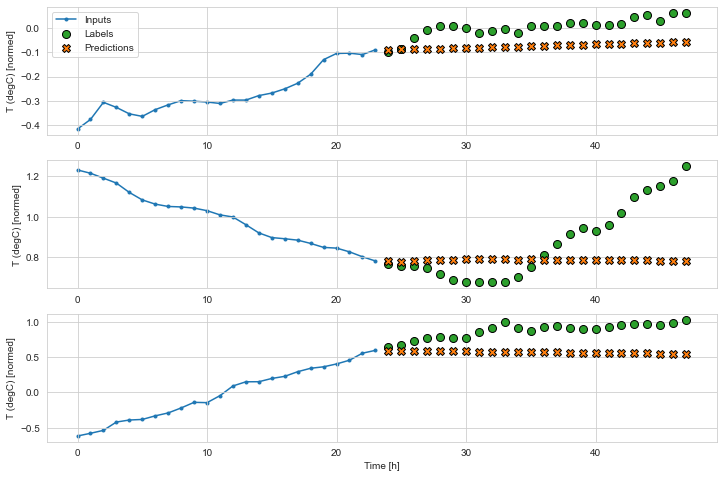

In [100]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

## Predicción

In [101]:
multi_linear_model.predict(input_predict_lstm)

array([[[ 1.3445191, -1.6079506,  1.9351205],
        [ 1.3448302, -1.6030332,  1.9270449],
        [ 1.3457453, -1.6056862,  1.9260621],
        [ 1.3468964, -1.6099361,  1.9273553],
        [ 1.348632 , -1.612753 ,  1.9280932],
        [ 1.3496499, -1.6139874,  1.9275652],
        [ 1.3491517, -1.6147316,  1.9266587],
        [ 1.3483691, -1.6151898,  1.9261203],
        [ 1.3469766, -1.6128541,  1.9227269],
        [ 1.3472406, -1.609131 ,  1.9184432],
        [ 1.3452046, -1.6022699,  1.9104204],
        [ 1.3443459, -1.5989408,  1.9062161],
        [ 1.3432391, -1.59562  ,  1.9021989],
        [ 1.3423605, -1.592676 ,  1.89884  ],
        [ 1.340701 , -1.5891192,  1.8949715],
        [ 1.3386401, -1.583493 ,  1.8886511],
        [ 1.3366448, -1.5776439,  1.8823901],
        [ 1.3350998, -1.5725081,  1.876627 ],
        [ 1.3326946, -1.5668279,  1.8705479],
        [ 1.33104  , -1.5614905,  1.8646463],
        [ 1.329538 , -1.5572821,  1.8599144],
        [ 1.3281286, -1.5512927,  

# Denso(MLP)

Se agrega una capa Densa con función de activación relu

1314/1314 [==============================] - 2s 2ms/step - loss: 0.0357 - mean_absolute_error: 0.1270


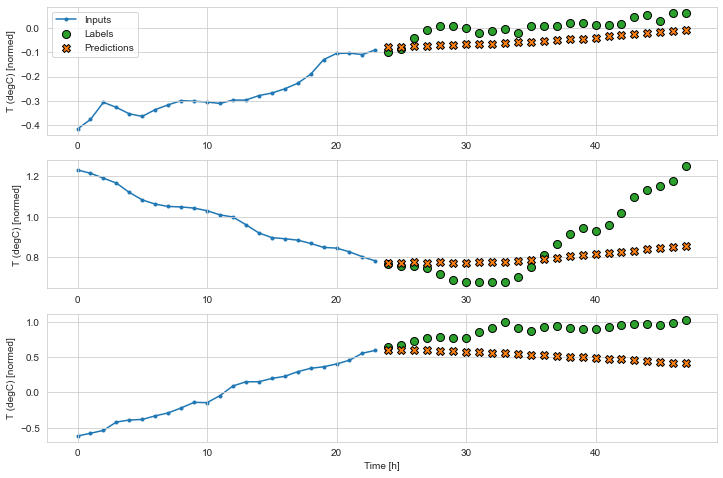

In [102]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

## Predicción

In [103]:
multi_dense_model(input_predict_lstm)

<tf.Tensor: shape=(1, 24, 3), dtype=float32, numpy=
array([[[ 1.2733256, -1.60732  ,  1.8992318],
        [ 1.2755241, -1.6037796,  1.8972596],
        [ 1.2802463, -1.6042857,  1.8935083],
        [ 1.2833241, -1.5986547,  1.8835865],
        [ 1.2868339, -1.5881003,  1.8749366],
        [ 1.2907896, -1.5795414,  1.8701268],
        [ 1.2958792, -1.5708323,  1.8644742],
        [ 1.2985382, -1.561568 ,  1.8576646],
        [ 1.3003128, -1.560868 ,  1.8579675],
        [ 1.3014383, -1.5599962,  1.8585036],
        [ 1.3009294, -1.5566008,  1.8551904],
        [ 1.3018967, -1.5561571,  1.8558218],
        [ 1.3007597, -1.551922 ,  1.8527324],
        [ 1.299645 , -1.5432353,  1.843919 ],
        [ 1.2970655, -1.5316325,  1.8330508],
        [ 1.2963165, -1.5231347,  1.8254493],
        [ 1.2944741, -1.5159775,  1.818639 ],
        [ 1.294484 , -1.507221 ,  1.8111906],
        [ 1.2919079, -1.4962423,  1.8004848],
        [ 1.2922862, -1.4836321,  1.7882493],
        [ 1.2937285, -1.4747

# Convolucional 

La red MLP se basa únicamnente en el pasado reciente(último dato) para predecir el futuro. Un modelo convolucional hace predicciones basadas en un historial de ancho fijo, lo que puede conducir a un mejor rendimiento que el modelo denso, ya que puede ver cómo cambian las cosas con el tiempo, para este caso se toma los útimos 24 periodos:
<img src="CNN.png">


1314/1314 [==============================] - 2s 1ms/step - loss: 0.0236 - mean_absolute_error: 0.1023


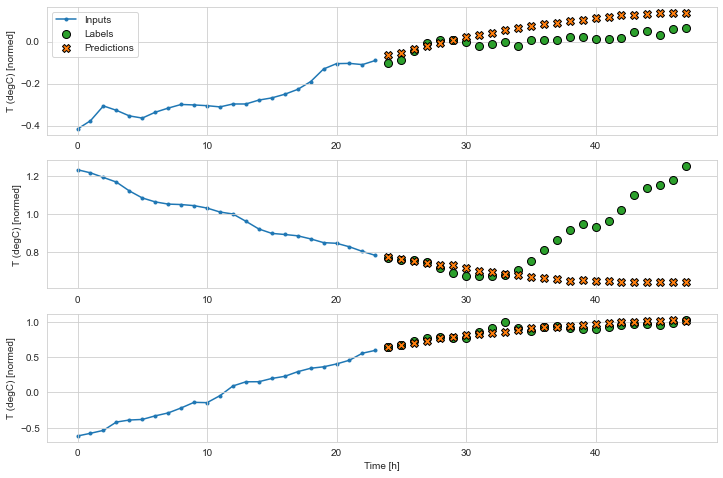

In [104]:
CONV_WIDTH = 24
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

# Predicción

In [105]:
multi_conv_model.predict(input_predict_lstm)

array([[[ 1.3030361, -1.5297089,  1.8510075],
        [ 1.2930214, -1.5447228,  1.866237 ],
        [ 1.2889901, -1.5546093,  1.8758492],
        [ 1.2785603, -1.561827 ,  1.88024  ],
        [ 1.2693417, -1.5607513,  1.8764795],
        [ 1.2650403, -1.564715 ,  1.8798254],
        [ 1.2596049, -1.5756412,  1.888633 ],
        [ 1.2555453, -1.5800923,  1.8908634],
        [ 1.2536099, -1.5784665,  1.8882911],
        [ 1.2524364, -1.5733293,  1.882713 ],
        [ 1.2537055, -1.5737755,  1.8823233],
        [ 1.249175 , -1.5720199,  1.8789636],
        [ 1.2479972, -1.5747453,  1.8799158],
        [ 1.2426267, -1.5744475,  1.8773681],
        [ 1.2376293, -1.5729418,  1.8745284],
        [ 1.2352773, -1.5735687,  1.8741463],
        [ 1.235489 , -1.5662953,  1.8659439],
        [ 1.2309407, -1.5527505,  1.8513695],
        [ 1.2264959, -1.54215  ,  1.8391848],
        [ 1.221684 , -1.5355595,  1.8304075],
        [ 1.2159817, -1.5265179,  1.8196994],
        [ 1.2111434, -1.5202085,  

# Red Neuronal Recurrente

Un modelo recurrente puede aprender a usar un largo historial de entradas, si es relevante para las predicciones que hace el modelo. Aquí el modelo acumulará el estado interno durante 24 horas, antes de hacer una sola predicción para las próximas 24 horas.

En este formato de disparo único, el LSTM solo necesita producir una salida en el último paso de tiempo, por lo tanto, establezca return_sequences=False en tf.keras.layers.LSTM .

<img src="RNNMutiple.png">

1314/1314 [==============================] - 3s 2ms/step - loss: 0.0213 - mean_absolute_error: 0.0935


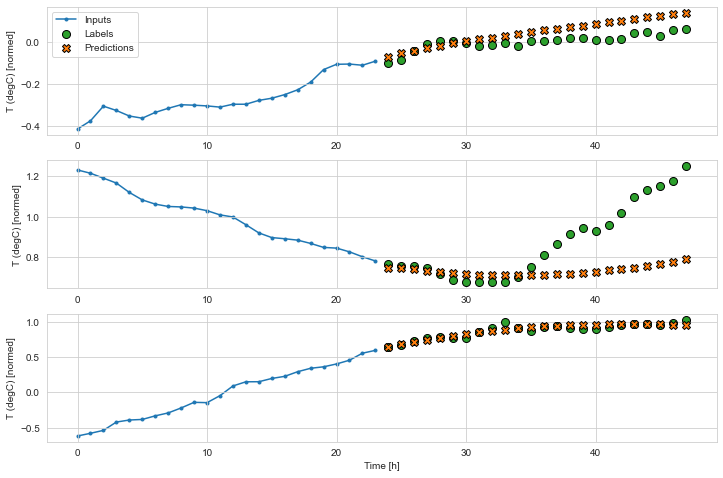

In [106]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

# Predicción

In [107]:
multi_lstm_model.predict(input_predict_lstm)

array([[[ 1.3352337, -1.6437275,  1.9622236],
        [ 1.329431 , -1.6508225,  1.9664065],
        [ 1.324375 , -1.6588155,  1.973053 ],
        [ 1.3201103, -1.6682832,  1.9817882],
        [ 1.3138127, -1.6791521,  1.990935 ],
        [ 1.306285 , -1.6903584,  1.9997311],
        [ 1.3049382, -1.7017248,  2.0095897],
        [ 1.2988143, -1.7169015,  2.0229192],
        [ 1.2907072, -1.7305566,  2.0344849],
        [ 1.2812239, -1.7429246,  2.0444674],
        [ 1.2735567, -1.7539101,  2.052694 ],
        [ 1.2655393, -1.7624738,  2.058619 ],
        [ 1.2576387, -1.7713938,  2.065249 ],
        [ 1.2515776, -1.7794026,  2.0709527],
        [ 1.2447416, -1.786087 ,  2.0752466],
        [ 1.2383293, -1.790186 ,  2.0773275],
        [ 1.231047 , -1.7959945,  2.0810814],
        [ 1.2252033, -1.8009087,  2.0842273],
        [ 1.2187682, -1.8042051,  2.085944 ],
        [ 1.2129512, -1.8054961,  2.0857127],
        [ 1.2075849, -1.8062463,  2.0848916],
        [ 1.2022344, -1.8075291,  

# Avanzado: modelo autorregresivo

Todos los modelos anteriores predicen la secuencia de salida completa en un solo paso.

En algunos casos, puede ser útil para el modelo descomponer esta predicción en pasos de tiempo individuales. Luego, la salida de cada modelo se puede retroalimentar en cada paso y se pueden hacer predicciones condicionadas a la anterior, como en el clásico Generating Sequences With Recurrent Neural Networks .

Una clara ventaja de este estilo de modelo es que se puede configurar para producir resultados con una longitud variable.

Puede tomar cualquiera de los modelos de salida múltiple de un solo paso entrenados en la primera mitad de este tutorial y ejecutarlo en un ciclo de retroalimentación autorregresivo, pero aquí se concentrará en crear un modelo que haya sido entrenado explícitamente para hacer eso.

<img src="ModeloAutoregresivoRNN.png">

En este caso, el modelo tiene que administrar manualmente las entradas para cada paso, por lo que usa tf.keras.layers.LSTMCell directamente para la interfaz de paso de tiempo único de nivel inferior.

In [108]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [109]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

El primer método que necesita este modelo es un método de warmup para inicializar su estado interno en función de las entradas. Una vez entrenado, este estado capturará las partes relevantes del historial de entrada. Esto es equivalente al modelo LSTM de un solo paso anterior:

In [110]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [111]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([64, 3])

Con el estado de RNN y una predicción inicial, ahora puede continuar iterando el modelo alimentando las predicciones en cada paso hacia atrás como entrada.

El enfoque más simple para recopilar las predicciones de salida es usar una lista de Python y un tf.stack después del bucle.

In [112]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [113]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (64, 24, 3)


Ahora, entrena el modelo:

1314/1314 [==============================] - 5s 4ms/step - loss: 0.0300 - mean_absolute_error: 0.1185


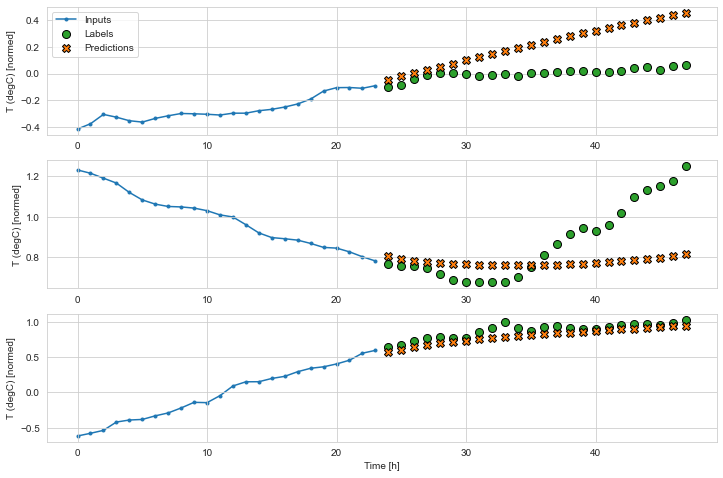

In [114]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

# Predicción

In [115]:
feedback_model.predict(input_predict_lstm)

array([[[ 1.305851 , -1.5406916,  1.8663206],
        [ 1.2955861, -1.5449237,  1.8691646],
        [ 1.2818258, -1.5462083,  1.8658774],
        [ 1.269246 , -1.546245 ,  1.8616549],
        [ 1.2565634, -1.5443394,  1.8554313],
        [ 1.2438838, -1.541002 ,  1.8477861],
        [ 1.2311743, -1.5365226,  1.8390222],
        [ 1.218461 , -1.53117  ,  1.8294276],
        [ 1.2057662, -1.5251493,  1.8192189],
        [ 1.1931111, -1.5186206,  1.8085638],
        [ 1.1805106, -1.511705 ,  1.7975873],
        [ 1.1679758, -1.5044936,  1.7863808],
        [ 1.1555101, -1.4970552,  1.7750105],
        [ 1.1431135, -1.4894406,  1.7635235],
        [ 1.1307819, -1.481687 ,  1.7519535],
        [ 1.1185085, -1.4738241,  1.7403237],
        [ 1.1062851, -1.4658743,  1.7286514],
        [ 1.0941025, -1.4578545,  1.7169495],
        [ 1.0819514, -1.44978  ,  1.7052277],
        [ 1.0698225, -1.4416625,  1.6934946],
        [ 1.0577071, -1.4335133,  1.6817567],
        [ 1.0455966, -1.4253426,  

# Rendimiento

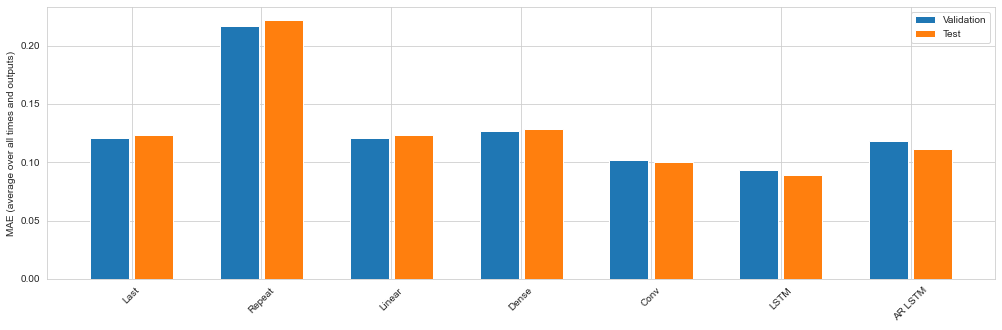

In [116]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()